# CommonLit Readability - DistilBERT fine tuning and data augmentation
This notebook is using DistilBert fine tuning for the CommonLit readability competition, with kfold validation.

Most of the code comes from S Canisir's notebooks : https://www.kaggle.com/snnclsr/commonlit-pytorch-distilbert-training  
With the help of V Baskaran's work as well : https://www.kaggle.com/vigneshbaskaran/commonlit-easy-transformer-finetuner  

My first attempts concentrated on using DistilBERT with some linear and dropout layers, not freezing any parameter. The global model was then built with around 66 millions parameters to update. With the small number of data available, it turned out to overfit a lot, even with the dropout layer : loss curve decreasing a lot on training set but not on validation set.   
  
I tried to freeze the 66 million parameters of the DistilBERT model (see Model class), to make it possible to train the model with the amount of data provided.    
  
I also tried to generate data augmentation on the texts (see parameter in CFG class).   
Be aware that it takes a long time to generate the augmented data, that's why I only augmented 10% of the data at each epoch.   
Note : to use NLPaug library offline, one should import it as a dataset.


# Imports

In [1]:
import os
import time
import math
import gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import KFold
from sklearn import metrics

from transformers import DistilBertTokenizer
from transformers import DistilBertModel

from logging import getLogger
from logging import INFO
from logging import FileHandler
from logging import Formatter
from logging import StreamHandler
from pathlib import Path

# text augmentation library
!cp ../input/nlpaug-114/nlpaug-1.1.4-py3-none-any.whl /kaggle/working/
!pip install --no-index --find-links /kaggle/working/ nlpaug
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

Looking in links: /kaggle/working/
Processing ./nlpaug-1.1.4-py3-none-any.whl


In [2]:
# clean memory
gc.collect()
torch.cuda.empty_cache()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data Loading

In [4]:
OUTPUT_DIR = "./"
BASE_DATA_PATH = Path("../input/commonlitreadabilityprize/")

!ls {BASE_DATA_PATH}

sample_submission.csv  test.csv  train.csv


,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676


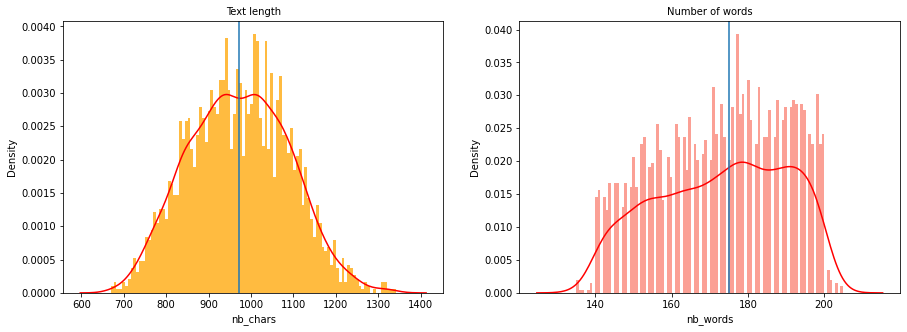

In [5]:
df_train = pd.read_csv(BASE_DATA_PATH / "train.csv")
display(df_train.head(3))

# explore excerpt
df_train['nb_words'] = df_train.excerpt.apply(lambda x: len(x.split()))
df_train['nb_chars'] = df_train.excerpt.apply(lambda x: len(x))

# plot histograms
fix, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_train, x="nb_chars", bins=100, ax=ax[0],
             color='orange', edgecolor=None, stat='density')
sns.kdeplot(data=df_train, x="nb_chars", color='red', ax=ax[0])
ax[0].axvline(np.median(df_train.nb_chars), 0, np.max(df_train.nb_chars))
ax[0].set_title('Text length', fontsize=10)

sns.histplot(data=df_train, x="nb_words", bins=100, ax=ax[1],
             color='salmon', edgecolor=None, stat='density')
sns.kdeplot(data=df_train, x="nb_words", color='red', ax=ax[1])
ax[1].axvline(np.median(df_train.nb_words), 0, np.max(df_train.nb_words))
ax[1].set_title('Number of words', fontsize=10)

plt.show()

Values of the target : -3.676267773 -> 1.7113898269999999


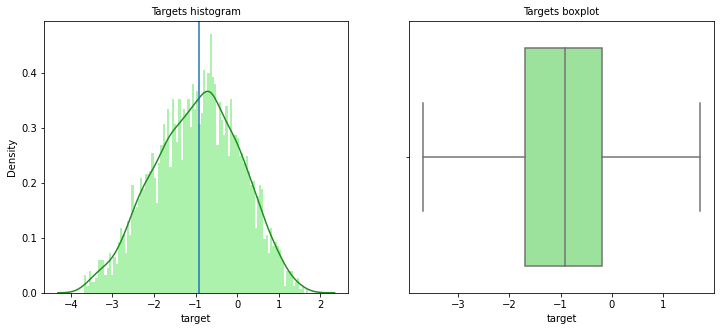

In [6]:
# target labels
labels = df_train['target']
print("Values of the target : {} -> {}".format(labels.min(), labels.max()))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=df_train, x="target", bins=100, ax=ax[0],
             color='lightgreen', edgecolor=None, stat='density')
sns.kdeplot(data=df_train, x="target", ax=ax[0], color='forestgreen')
ax[0].axvline(np.median(df_train.target), 0, np.max(df_train.target))
ax[0].set_title('Targets histogram', fontsize=10)

sns.boxplot(x=df_train["target"], ax=ax[1], color='lightgreen')
ax[1].set_title('Targets boxplot', fontsize=10)
plt.show()

# Utils

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value
    of a given object:
    val is the current value
    sum is the total sum of all increments
    count is the number of increments
    avg is the mean increment"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.cur_val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.cur_val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class Metric:
    """sums the squared residuals (target - excepted) for a period (epoch)
    and returns the rmse for the whole epoch data"""

    def __init__(self):
        self.sse = 0
        self.num_samples = 0

    def update(self, targets, predictions):
        predictions = flatten(predictions)
        self.sse += np.sum(np.square(targets - predictions))
        self.num_samples += len(targets)

    def get_rmse(self):
        rmse = np.sqrt(self.sse / self.num_samples)
        return rmse


def flatten(array):
    """takes an output array and flatten it
    returns a list"""

    my_list = []
    for i in range(len(array)):
        my_list.append(array[i][0])
    return np.array(my_list)


def asMinutes(s):
    """converts seconds to minutes"""

    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """returns the time elapsed from the 'since' point
    and an estimation of the remaining time
    percent : current % of progress compared to total length"""

    now = time.time()
    elapsed = now - since
    estimated = elapsed / (percent)
    remaining = estimated - elapsed
    return '%s (remain %s)' % (asMinutes(elapsed), asMinutes(remaining))


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    """initiate logger"""
    logger = getLogger(__name__)
    logger.setLevel(INFO)

    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))

    logger.handlers.clear()
    logger.addHandler(handler1)
    logger.addHandler(handler2)

    return logger


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def get_scheduler(optimizer):
    """instanciate a scheduler to update learning rate"""
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max=CFG.T_max,
                                                         eta_min=CFG.min_lr,
                                                         last_epoch=-1)
    if CFG.scheduler == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer,
                                              step_size=30,
                                              gamma=0.1)
    return scheduler


def get_optimizer(model):
    """instanciate an optimizer
    weight_decay is for L2 regularization"""
    if CFG.optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=CFG.lr,
                               weight_decay=CFG.weight_decay)
    if CFG.optimizer == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=CFG.lr,
                                  weight_decay=CFG.weight_decay)
    if CFG.optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr,
                              weight_decay=CFG.weight_decay)
    return optimizer

# Configuration

In [8]:
class CFG:
    model_name = "distilbert-base-uncased"
    model_path = "../input/distilbertbaseuncased"
    max_length = 256
    dropout_p = 0.4
    batch_size = 32
    n_epochs = 10
    weight_decay = 1e-6
    lr = 3e-4
    min_lr = 1e-6
    scheduler = "CosineAnnealingLR"
    optimizer = "Adam"
    T_max = 10
    seed = 28
    n_folds = 5
    print_freq = 50
    num_workers = 4
    augment_text = False
    augment_ratio = 0.1


# Dataset

In [9]:
def augment_sentences(text, action='switch'):
    """switches or deletes randomly sentences in the text
    warning : looses the different ponctuations (only dots)"""
    list_replace = ['.', '!', '?', '...']
    sep = '.'
    for char in list_replace:
        text = text.replace(char, sep)
    sentences = text.split(sep)
    sentences = [x for x in sentences if x]  # cleans empty sentences
    nb_sentences = len(sentences)

    if (action == 'switch') & (nb_sentences > 1):
        sents = random.sample(range(nb_sentences), 2)
        s0 = sentences[sents[0]]
        s1 = sentences[sents[1]]
        sentences[sents[0]] = s1
        sentences[sents[1]] = s0
        augmented_text = '. '.join(sentences)
        del(s0, s1)
        return augmented_text + '.'
    elif (action == 'delete') & (nb_sentences > 0):
        sents = random.sample(range(nb_sentences), 1)
        del sentences[sents[0]]
        augmented_text = '. '.join(sentences)
        return augmented_text + '.'
    else:
        return text


def augment_words(text, action='delete'):
    """words random augmentations
    uses NLPAug library:
    with ‘swap’, ‘delete’ or ‘crop’ actions
    insertion with distilbert model """
    augmented_text = ''
    if action in ['delete', 'crop', 'swap']:
        aug = naw.RandomWordAug(action=action, aug_p=0.3,
                                aug_min=5, aug_max=50)
    elif action in ['insert']:
        aug = naw.ContextualWordEmbsAug(model_path=CFG.model_path,
                                        action=action)

    augmented_text = aug.augment(text)
    return augmented_text


def apply_augment(text):
    """randomly applies 1 augmentation on sentence level
    and 1 augmentation on word level"""

    list_aug_sentence = ['switch', 'delete']
    list_aug_word = ['delete', 'crop', 'swap', 'insert']

    # pick randomly 2 transformations
    trans_s = random.sample(range(len(list_aug_sentence)), 1)[0]
    trans_w = random.sample(range(len(list_aug_word)), 1)[0]

    aug_text = augment_sentences(text, action=list_aug_sentence[trans_s])
    aug_text = augment_words(aug_text, action=list_aug_word[trans_w])
    return aug_text

In [10]:
class CommonLitDataset(Dataset):

    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        tokenized_input = self.tokenizer(row.excerpt, return_tensors="pt",
                                         max_length=self.max_length,
                                         padding="max_length", truncation=True)

        return {
                "ids": tokenized_input["input_ids"][0],
                "masks": tokenized_input["attention_mask"][0],
                "targets": torch.tensor(row.target).float()
        }

# Model

In [11]:
class TextRegressionModel(nn.Module):

    def __init__(self, model_name, dropout_p=0.3):
        super(TextRegressionModel, self).__init__()

        # load DistilBERT model
        self.model = DistilBertModel.from_pretrained(CFG.model_path)
        # and freeze its parameters if wanted
        # for param in self.model.parameters():
        # param.requires_grad = False

        # define other layers
        self.features = nn.Linear(768, 200)
        self.dropout = nn.Dropout(dropout_p)
        self.regressor = nn.Linear(200, 1)
        self.list_layers = [self.model, self.features,
                            self.dropout, self.regressor]
        self.list_layers_names = ['DistilBERT', 'Features',
                                  'Dropout', 'Regressor']

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids,
                            attention_mask=attention_mask)
        output = output.last_hidden_state[:, 0]
        output = F.relu(self.features(output))
        output = self.dropout(output)
        output = self.regressor(output)
        return output

    def count_parameters(self):
        """counts number of trainable parameters"""
        total = 0
        for layer in self.list_layers:
            total += sum(p.numel() for p in layer.parameters()
                         if p.requires_grad)
        return total

    def details_parameters(self):
        """details the number of trainable parameters by layer"""

        for i in range(len(self.list_layers)):
            layer = self.list_layers[i]
            table = pd.DataFrame(columns=['module', 'parameters'])
            for name, parameter in layer.named_parameters():
                if not parameter.requires_grad:
                    continue
                param = parameter.numel()
                new_line = {'module': name, 'parameters': param}
                table.loc[len(table)] = new_line
            print(self.list_layers_names[i], 'layer :')
            display(table)

# Train and eval Functions

In [12]:
def train_step(model, criterion, optimizer, data_loader, epoch, device=device):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    train_loss = AverageMeter()
    metric = Metric()
    model.train()

    start = end = time.time()

    for step, batch in enumerate(data_loader):
        # update data loading time
        data_time.update(time.time() - end)

        # get data for the current batch
        input_ids = batch["ids"].to(device)
        attention_masks = batch["masks"].to(device)
        targets = batch["targets"].to(device)
        bs = input_ids.size(0)

        # compute output and loss
        output = model(input_ids, attention_masks)
        loss = criterion(output.squeeze(1), targets)
        train_loss.update(loss.item(), bs)
        # loss.item() is the avg of mse over the batch
        loss.backward()

        m_targets = targets.detach().cpu().numpy()
        m_predictions = output.detach().cpu().numpy()
        metric.update(targets=m_targets, predictions=m_predictions)

        # step optimizer
        optimizer.step()
        optimizer.zero_grad()

        # update batch time
        batch_time.update(time.time() - end)
        end = time.time()

        # if current step is a multiple of the printing param (or end)
        if step % CFG.print_freq == 0 or step == (len(data_loader) - 1):
            print('Epoch {0} [{1}/{2}]: '
                  'Elapsed {remain:s} '
                  'Loss: {loss.cur_val:.4f} (avg {loss.avg:.4f}) '
                  .format(
                      epoch+1, step, len(data_loader),
                      loss=train_loss,
                      remain=timeSince(start,
                                       float(step + 1) / len(data_loader))))

    rmse = metric.get_rmse()
    return train_loss.avg, rmse


def eval_step(model, criterion, data_loader, epoch, device=device):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    eval_loss = AverageMeter()
    metric = Metric()
    model.eval()

    start = end = time.time()

    for step, batch in enumerate(data_loader):
        data_time.update(time.time() - end)

        input_ids = batch["ids"].to(device)
        attention_masks = batch["masks"].to(device)
        targets = batch["targets"].to(device)
        bs = input_ids.size(0)
        with torch.no_grad():
            output = model(input_ids, attention_masks)
        loss = criterion(output.squeeze(1), targets)
        eval_loss.update(loss.item(), bs)
        batch_time.update(time.time() - end)
        end = time.time()

        m_targets = targets.detach().cpu().numpy()
        m_predictions = output.detach().cpu().numpy()
        metric.update(targets=m_targets, predictions=m_predictions)

        if step % CFG.print_freq == 0 or step == (len(data_loader) - 1):
            print('EVAL - Epoch {0} [{1}/{2}]: '
                  'Loss: {loss.cur_val:.4f} (avg {loss.avg:.4f}) '
                  .format(epoch+1, step, len(data_loader),
                          loss=eval_loss))
    rmse = metric.get_rmse()
    return eval_loss.avg, rmse

In [13]:
def train_loop(folds, fold):
    print('\n*** FOLD ', fold)

    # get indexes tagged for the current fold
    train_index = folds[folds["fold"] != fold].index
    valid_index = folds[folds["fold"] == fold].index

    # get data
    train_folds = folds.loc[train_index].reset_index(drop=True)
    valid_folds = folds.loc[valid_index].reset_index(drop=True)

    # create tokenizer and create dataset
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.model_path)
    tokenizer.save_pretrained(f"{CFG.model_name}_tokenizer")

    # create validation data loader
    valid_dataset = CommonLitDataset(df=valid_folds, tokenizer=tokenizer,
                                     max_length=CFG.max_length)
    valid_data_loader = DataLoader(valid_dataset,
                                   batch_size=CFG.batch_size,
                                   shuffle=False,
                                   num_workers=CFG.num_workers,
                                   pin_memory=True)

    # define scheduler, model, optimizer, loss
    model = TextRegressionModel(model_name=CFG.model_name,
                                dropout_p=CFG.dropout_p)
    model.to(device)
    if fold == 0:
        print('Model instanciated. Number of trainable parameters : {}\n'
              .format(model.count_parameters()))
        model.details_parameters()

    optimizer = get_optimizer(model)
    scheduler = get_scheduler(optimizer)

    criterion = nn.MSELoss().to(device)
    best_loss = np.inf  # initiate with positive infinity

    # iterate through epochs
    for epoch in range(CFG.n_epochs):

        # augment part of the data except for the first epoch
        if CFG.augment_text & (epoch != 0):
            print("Epoch {} - Augmenting data...".format(epoch + 1))
            start = time.time()
            ratio = CFG.augment_ratio
            idx_aug = random.sample(range(len(train_folds)),
                                    int(len(train_folds) * ratio))
            for idx in idx_aug:
                cur_excerpt = train_folds.loc[idx, 'excerpt']
                train_folds.loc[idx, 'excerpt'] = apply_augment(cur_excerpt)
            print("... done ({} sec)".format(round(time.time() - start)))

        # build train data loader
        train_dataset = CommonLitDataset(df=train_folds, tokenizer=tokenizer,
                                         max_length=CFG.max_length)
        train_data_loader = DataLoader(train_dataset,
                                       batch_size=CFG.batch_size,
                                       shuffle=True,
                                       num_workers=CFG.num_workers,
                                       pin_memory=True)

        # train and evaluate
        start_time = time.time()
        train_loss, train_rmse = train_step(model, criterion, optimizer,
                                            train_data_loader, epoch)
        eval_loss, eval_rmse = eval_step(model, criterion,
                                         valid_data_loader, epoch)
        scheduler.step()
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {train_loss:.4f}'
                    ' time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - avg_eval_loss: {eval_loss:.4f} '
                    '- avg_rmse: {eval_rmse:.4f}')
        save_training(fold, epoch, train_loss, eval_loss,
                      train_rmse, eval_rmse)

        # save best loss and model
        if eval_loss < best_loss:
            best_loss = eval_loss
            file_name = f"{CFG.model_name}_fold_{fold}_best.pth"
            print('  -> save model as', file_name)
            torch.save({
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict()
            }, file_name)

In [14]:
def save_training(fold, epoch, train_loss, val_loss, train_rmse, val_rmse):
    """stores the values of loss and rmse during training"""
    new_line = {'fold': fold, 'epoch': epoch,
                'train_loss': train_loss, 'val_loss': val_loss,
                'train_rmse': train_rmse, 'val_rmse': val_rmse}
    training_evals.loc[len(training_evals)] = new_line
    return training_evals

# Main

#### CV split

In [15]:
# separate the observations in CFG.n_folds folds
# the fold number is recorded in the 'fold' column of folds df
folds = df_train.copy()
Fold = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for n, (train_idx, valid_idx) in enumerate(Fold.split(folds)):
    folds.loc[valid_idx, "fold"] = int(n)

folds["fold"] = folds["fold"].astype(int)
print('Number of observations per fold :\n')
print(folds.groupby(["fold"]).size())

Number of observations per fold :

fold
0    567
1    567
2    567
3    567
4    566
dtype: int64


In [16]:
def main():
    for fold in range(CFG.n_folds):
        gc.collect()
        torch.cuda.empty_cache()
        train_loop(folds, fold)

In [17]:
# inits
seed_torch(seed=CFG.seed)
LOGGER = init_logger()
training_evals = pd.DataFrame(columns=['fold', 'epoch',
                                       'train_loss', 'val_loss',
                                       'train_rmse', 'val_rmse'])

# run training
main()


*** FOLD  0
Model instanciated. Number of trainable parameters : 66516881

DistilBERT layer :


,module,parameters
0,embeddings.word_embeddings.weight,23440896
1,embeddings.position_embeddings.weight,393216
2,embeddings.LayerNorm.weight,768
3,embeddings.LayerNorm.bias,768
4,transformer.layer.0.attention.q_lin.weight,589824
...,...,...
95,transformer.layer.5.ffn.lin1.bias,3072
96,transformer.layer.5.ffn.lin2.weight,2359296
97,transformer.layer.5.ffn.lin2.bias,768
98,transformer.layer.5.output_layer_norm.weight,768


Features layer :


,module,parameters
0,weight,153600
1,bias,200


Dropout layer :


,module,parameters


Regressor layer :


,module,parameters
0,weight,200
1,bias,1


Epoch 1 [0/71]: Elapsed 0m 2s (remain 2m 41s) Loss: 1.5328 (avg 1.5328) 
Epoch 1 [50/71]: Elapsed 0m 22s (remain 0m 8s) Loss: 0.2807 (avg 0.6910) 
Epoch 1 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.3671 (avg 0.6342) 
EVAL - Epoch 1 [0/18]: Loss: 0.2155 (avg 0.2155) 


Epoch 1 - avg_train_loss: 0.6342 time: {elapsed:.0f}s
Epoch 1 - avg_eval_loss: 0.3548 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 1 [17/18]: Loss: 0.3040 (avg 0.3548) 
  -> save model as distilbert-base-uncased_fold_0_best.pth
Epoch 2 [0/71]: Elapsed 0m 1s (remain 1m 28s) Loss: 0.2775 (avg 0.2775) 
Epoch 2 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.6055 (avg 0.3159) 
Epoch 2 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.2995 (avg 0.3106) 
EVAL - Epoch 2 [0/18]: Loss: 0.4600 (avg 0.4600) 


Epoch 2 - avg_train_loss: 0.3106 time: {elapsed:.0f}s
Epoch 2 - avg_eval_loss: 0.5217 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 2 [17/18]: Loss: 0.6616 (avg 0.5217) 
Epoch 3 [0/71]: Elapsed 0m 1s (remain 1m 54s) Loss: 0.2944 (avg 0.2944) 
Epoch 3 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.2278 (avg 0.2197) 
Epoch 3 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.1523 (avg 0.2031) 
EVAL - Epoch 3 [0/18]: Loss: 0.1932 (avg 0.1932) 


Epoch 3 - avg_train_loss: 0.2031 time: {elapsed:.0f}s
Epoch 3 - avg_eval_loss: 0.3527 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 3 [17/18]: Loss: 0.3316 (avg 0.3527) 
  -> save model as distilbert-base-uncased_fold_0_best.pth
Epoch 4 [0/71]: Elapsed 0m 1s (remain 1m 23s) Loss: 0.2239 (avg 0.2239) 
Epoch 4 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.1440 (avg 0.1357) 
Epoch 4 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1358 (avg 0.1359) 
EVAL - Epoch 4 [0/18]: Loss: 0.2376 (avg 0.2376) 


Epoch 4 - avg_train_loss: 0.1359 time: {elapsed:.0f}s
Epoch 4 - avg_eval_loss: 0.3484 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 4 [17/18]: Loss: 0.2573 (avg 0.3484) 
  -> save model as distilbert-base-uncased_fold_0_best.pth
Epoch 5 [0/71]: Elapsed 0m 1s (remain 1m 28s) Loss: 0.1212 (avg 0.1212) 
Epoch 5 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0346 (avg 0.0862) 
Epoch 5 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1026 (avg 0.0854) 
EVAL - Epoch 5 [0/18]: Loss: 0.2847 (avg 0.2847) 


Epoch 5 - avg_train_loss: 0.0854 time: {elapsed:.0f}s
Epoch 5 - avg_eval_loss: 0.3769 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 5 [17/18]: Loss: 0.3710 (avg 0.3769) 
Epoch 6 [0/71]: Elapsed 0m 1s (remain 1m 40s) Loss: 0.0338 (avg 0.0338) 
Epoch 6 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0629 (avg 0.0626) 
Epoch 6 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0815 (avg 0.0637) 
EVAL - Epoch 6 [0/18]: Loss: 0.2924 (avg 0.2924) 


Epoch 6 - avg_train_loss: 0.0637 time: {elapsed:.0f}s
Epoch 6 - avg_eval_loss: 0.3630 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 6 [17/18]: Loss: 0.3337 (avg 0.3630) 
Epoch 7 [0/71]: Elapsed 0m 1s (remain 2m 12s) Loss: 0.0425 (avg 0.0425) 
Epoch 7 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0507 (avg 0.0468) 
Epoch 7 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.0316 (avg 0.0456) 
EVAL - Epoch 7 [0/18]: Loss: 0.2363 (avg 0.2363) 


Epoch 7 - avg_train_loss: 0.0456 time: {elapsed:.0f}s
Epoch 7 - avg_eval_loss: 0.3356 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 7 [17/18]: Loss: 0.3030 (avg 0.3356) 
  -> save model as distilbert-base-uncased_fold_0_best.pth
Epoch 8 [0/71]: Elapsed 0m 1s (remain 1m 50s) Loss: 0.0358 (avg 0.0358) 
Epoch 8 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0825 (avg 0.0418) 
Epoch 8 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0375 (avg 0.0402) 
EVAL - Epoch 8 [0/18]: Loss: 0.2229 (avg 0.2229) 


Epoch 8 - avg_train_loss: 0.0402 time: {elapsed:.0f}s
Epoch 8 - avg_eval_loss: 0.3276 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 8 [17/18]: Loss: 0.3026 (avg 0.3276) 
  -> save model as distilbert-base-uncased_fold_0_best.pth
Epoch 9 [0/71]: Elapsed 0m 1s (remain 1m 22s) Loss: 0.0236 (avg 0.0236) 
Epoch 9 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0212 (avg 0.0341) 
Epoch 9 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0290 (avg 0.0348) 
EVAL - Epoch 9 [0/18]: Loss: 0.2230 (avg 0.2230) 


Epoch 9 - avg_train_loss: 0.0348 time: {elapsed:.0f}s
Epoch 9 - avg_eval_loss: 0.3294 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 9 [17/18]: Loss: 0.3069 (avg 0.3294) 
Epoch 10 [0/71]: Elapsed 0m 1s (remain 1m 30s) Loss: 0.0336 (avg 0.0336) 
Epoch 10 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0624 (avg 0.0309) 
Epoch 10 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0312 (avg 0.0303) 
EVAL - Epoch 10 [0/18]: Loss: 0.2211 (avg 0.2211) 


Epoch 10 - avg_train_loss: 0.0303 time: {elapsed:.0f}s
Epoch 10 - avg_eval_loss: 0.3282 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 10 [17/18]: Loss: 0.3030 (avg 0.3282) 

*** FOLD  1
Epoch 1 [0/71]: Elapsed 0m 1s (remain 1m 39s) Loss: 1.6688 (avg 1.6688) 
Epoch 1 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.1641 (avg 0.6568) 
Epoch 1 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.4042 (avg 0.6134) 
EVAL - Epoch 1 [0/18]: Loss: 0.3862 (avg 0.3862) 


Epoch 1 - avg_train_loss: 0.6134 time: {elapsed:.0f}s
Epoch 1 - avg_eval_loss: 0.4697 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 1 [17/18]: Loss: 0.7566 (avg 0.4697) 
  -> save model as distilbert-base-uncased_fold_1_best.pth
Epoch 2 [0/71]: Elapsed 0m 1s (remain 1m 27s) Loss: 0.3366 (avg 0.3366) 
Epoch 2 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.5816 (avg 0.2935) 
Epoch 2 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.2963 (avg 0.3076) 
EVAL - Epoch 2 [0/18]: Loss: 0.3173 (avg 0.3173) 


Epoch 2 - avg_train_loss: 0.3076 time: {elapsed:.0f}s
Epoch 2 - avg_eval_loss: 0.4449 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 2 [17/18]: Loss: 0.7252 (avg 0.4449) 
  -> save model as distilbert-base-uncased_fold_1_best.pth
Epoch 3 [0/71]: Elapsed 0m 0s (remain 1m 7s) Loss: 0.2468 (avg 0.2468) 
Epoch 3 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.2406 (avg 0.1690) 
Epoch 3 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1371 (avg 0.1710) 
EVAL - Epoch 3 [0/18]: Loss: 0.3943 (avg 0.3943) 


Epoch 3 - avg_train_loss: 0.1710 time: {elapsed:.0f}s
Epoch 3 - avg_eval_loss: 0.3835 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 3 [17/18]: Loss: 0.3951 (avg 0.3835) 
  -> save model as distilbert-base-uncased_fold_1_best.pth
Epoch 4 [0/71]: Elapsed 0m 1s (remain 1m 26s) Loss: 0.0885 (avg 0.0885) 
Epoch 4 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0922 (avg 0.1051) 
Epoch 4 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1101 (avg 0.1059) 
EVAL - Epoch 4 [0/18]: Loss: 0.2796 (avg 0.2796) 


Epoch 4 - avg_train_loss: 0.1059 time: {elapsed:.0f}s
Epoch 4 - avg_eval_loss: 0.3593 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 4 [17/18]: Loss: 0.4380 (avg 0.3593) 
  -> save model as distilbert-base-uncased_fold_1_best.pth
Epoch 5 [0/71]: Elapsed 0m 1s (remain 1m 16s) Loss: 0.0718 (avg 0.0718) 
Epoch 5 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0848 (avg 0.0783) 
Epoch 5 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0639 (avg 0.0781) 
EVAL - Epoch 5 [0/18]: Loss: 0.2824 (avg 0.2824) 


Epoch 5 - avg_train_loss: 0.0781 time: {elapsed:.0f}s
Epoch 5 - avg_eval_loss: 0.3633 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 5 [17/18]: Loss: 0.4493 (avg 0.3633) 
Epoch 6 [0/71]: Elapsed 0m 1s (remain 1m 33s) Loss: 0.0309 (avg 0.0309) 
Epoch 6 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0467 (avg 0.0578) 
Epoch 6 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0853 (avg 0.0564) 
EVAL - Epoch 6 [0/18]: Loss: 0.2748 (avg 0.2748) 


Epoch 6 - avg_train_loss: 0.0564 time: {elapsed:.0f}s
Epoch 6 - avg_eval_loss: 0.3659 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 6 [17/18]: Loss: 0.5062 (avg 0.3659) 
Epoch 7 [0/71]: Elapsed 0m 1s (remain 1m 28s) Loss: 0.0269 (avg 0.0269) 
Epoch 7 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0395 (avg 0.0445) 
Epoch 7 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0285 (avg 0.0470) 
EVAL - Epoch 7 [0/18]: Loss: 0.2845 (avg 0.2845) 


Epoch 7 - avg_train_loss: 0.0470 time: {elapsed:.0f}s
Epoch 7 - avg_eval_loss: 0.3651 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 7 [17/18]: Loss: 0.4536 (avg 0.3651) 
Epoch 8 [0/71]: Elapsed 0m 1s (remain 1m 28s) Loss: 0.0661 (avg 0.0661) 
Epoch 8 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0253 (avg 0.0368) 
Epoch 8 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0259 (avg 0.0355) 
EVAL - Epoch 8 [0/18]: Loss: 0.2732 (avg 0.2732) 


Epoch 8 - avg_train_loss: 0.0355 time: {elapsed:.0f}s
Epoch 8 - avg_eval_loss: 0.3586 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 8 [17/18]: Loss: 0.4431 (avg 0.3586) 
  -> save model as distilbert-base-uncased_fold_1_best.pth
Epoch 9 [0/71]: Elapsed 0m 1s (remain 1m 30s) Loss: 0.0379 (avg 0.0379) 
Epoch 9 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0453 (avg 0.0339) 
Epoch 9 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0235 (avg 0.0314) 
EVAL - Epoch 9 [0/18]: Loss: 0.2649 (avg 0.2649) 


Epoch 9 - avg_train_loss: 0.0314 time: {elapsed:.0f}s
Epoch 9 - avg_eval_loss: 0.3575 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 9 [17/18]: Loss: 0.4467 (avg 0.3575) 
  -> save model as distilbert-base-uncased_fold_1_best.pth
Epoch 10 [0/71]: Elapsed 0m 1s (remain 1m 42s) Loss: 0.0232 (avg 0.0232) 
Epoch 10 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0274 (avg 0.0317) 
Epoch 10 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0372 (avg 0.0306) 
EVAL - Epoch 10 [0/18]: Loss: 0.2660 (avg 0.2660) 


Epoch 10 - avg_train_loss: 0.0306 time: {elapsed:.0f}s
Epoch 10 - avg_eval_loss: 0.3565 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 10 [17/18]: Loss: 0.4482 (avg 0.3565) 
  -> save model as distilbert-base-uncased_fold_1_best.pth

*** FOLD  2
Epoch 1 [0/71]: Elapsed 0m 1s (remain 1m 20s) Loss: 2.3740 (avg 2.3740) 
Epoch 1 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.4446 (avg 0.7287) 
Epoch 1 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.5519 (avg 0.6620) 
EVAL - Epoch 1 [0/18]: Loss: 0.3996 (avg 0.3996) 


Epoch 1 - avg_train_loss: 0.6620 time: {elapsed:.0f}s
Epoch 1 - avg_eval_loss: 0.4902 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 1 [17/18]: Loss: 0.3482 (avg 0.4902) 
  -> save model as distilbert-base-uncased_fold_2_best.pth
Epoch 2 [0/71]: Elapsed 0m 1s (remain 1m 26s) Loss: 0.5475 (avg 0.5475) 
Epoch 2 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.4868 (avg 0.3705) 
Epoch 2 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.5147 (avg 0.3686) 
EVAL - Epoch 2 [0/18]: Loss: 0.3361 (avg 0.3361) 


Epoch 2 - avg_train_loss: 0.3686 time: {elapsed:.0f}s
Epoch 2 - avg_eval_loss: 0.3906 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 2 [17/18]: Loss: 0.3139 (avg 0.3906) 
  -> save model as distilbert-base-uncased_fold_2_best.pth
Epoch 3 [0/71]: Elapsed 0m 1s (remain 1m 31s) Loss: 0.1513 (avg 0.1513) 
Epoch 3 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.3358 (avg 0.2198) 
Epoch 3 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.2560 (avg 0.2205) 
EVAL - Epoch 3 [0/18]: Loss: 0.3109 (avg 0.3109) 


Epoch 3 - avg_train_loss: 0.2205 time: {elapsed:.0f}s
Epoch 3 - avg_eval_loss: 0.3868 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 3 [17/18]: Loss: 0.4083 (avg 0.3868) 
  -> save model as distilbert-base-uncased_fold_2_best.pth
Epoch 4 [0/71]: Elapsed 0m 1s (remain 1m 26s) Loss: 0.1912 (avg 0.1912) 
Epoch 4 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.1695 (avg 0.1377) 
Epoch 4 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1866 (avg 0.1338) 
EVAL - Epoch 4 [0/18]: Loss: 0.3284 (avg 0.3284) 


Epoch 4 - avg_train_loss: 0.1338 time: {elapsed:.0f}s
Epoch 4 - avg_eval_loss: 0.3792 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 4 [17/18]: Loss: 0.3453 (avg 0.3792) 
  -> save model as distilbert-base-uncased_fold_2_best.pth
Epoch 5 [0/71]: Elapsed 0m 1s (remain 1m 47s) Loss: 0.1170 (avg 0.1170) 
Epoch 5 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0715 (avg 0.0993) 
Epoch 5 [70/71]: Elapsed 0m 29s (remain 0m 0s) Loss: 0.0871 (avg 0.0974) 
EVAL - Epoch 5 [0/18]: Loss: 0.3228 (avg 0.3228) 


Epoch 5 - avg_train_loss: 0.0974 time: {elapsed:.0f}s
Epoch 5 - avg_eval_loss: 0.3850 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 5 [17/18]: Loss: 0.3996 (avg 0.3850) 
Epoch 6 [0/71]: Elapsed 0m 1s (remain 1m 37s) Loss: 0.0565 (avg 0.0565) 
Epoch 6 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.1056 (avg 0.0683) 
Epoch 6 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0807 (avg 0.0743) 
EVAL - Epoch 6 [0/18]: Loss: 0.3076 (avg 0.3076) 


Epoch 6 - avg_train_loss: 0.0743 time: {elapsed:.0f}s
Epoch 6 - avg_eval_loss: 0.4009 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 6 [17/18]: Loss: 0.3884 (avg 0.4009) 
Epoch 7 [0/71]: Elapsed 0m 1s (remain 1m 37s) Loss: 0.0710 (avg 0.0710) 
Epoch 7 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0864 (avg 0.0583) 
Epoch 7 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0466 (avg 0.0565) 
EVAL - Epoch 7 [0/18]: Loss: 0.3071 (avg 0.3071) 


Epoch 7 - avg_train_loss: 0.0565 time: {elapsed:.0f}s
Epoch 7 - avg_eval_loss: 0.3779 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 7 [17/18]: Loss: 0.3757 (avg 0.3779) 
  -> save model as distilbert-base-uncased_fold_2_best.pth
Epoch 8 [0/71]: Elapsed 0m 1s (remain 1m 32s) Loss: 0.0501 (avg 0.0501) 
Epoch 8 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0533 (avg 0.0458) 
Epoch 8 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0362 (avg 0.0478) 
EVAL - Epoch 8 [0/18]: Loss: 0.2954 (avg 0.2954) 


Epoch 8 - avg_train_loss: 0.0478 time: {elapsed:.0f}s
Epoch 8 - avg_eval_loss: 0.3711 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 8 [17/18]: Loss: 0.3736 (avg 0.3711) 
  -> save model as distilbert-base-uncased_fold_2_best.pth
Epoch 9 [0/71]: Elapsed 0m 1s (remain 1m 28s) Loss: 0.0470 (avg 0.0470) 
Epoch 9 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0206 (avg 0.0382) 
Epoch 9 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0166 (avg 0.0384) 
EVAL - Epoch 9 [0/18]: Loss: 0.3047 (avg 0.3047) 


Epoch 9 - avg_train_loss: 0.0384 time: {elapsed:.0f}s
Epoch 9 - avg_eval_loss: 0.3759 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 9 [17/18]: Loss: 0.3797 (avg 0.3759) 
Epoch 10 [0/71]: Elapsed 0m 1s (remain 1m 45s) Loss: 0.0135 (avg 0.0135) 
Epoch 10 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0210 (avg 0.0344) 
Epoch 10 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0189 (avg 0.0329) 
EVAL - Epoch 10 [0/18]: Loss: 0.2992 (avg 0.2992) 


Epoch 10 - avg_train_loss: 0.0329 time: {elapsed:.0f}s
Epoch 10 - avg_eval_loss: 0.3742 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 10 [17/18]: Loss: 0.3777 (avg 0.3742) 

*** FOLD  3
Epoch 1 [0/71]: Elapsed 0m 1s (remain 1m 33s) Loss: 2.1985 (avg 2.1985) 
Epoch 1 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.8591 (avg 1.1188) 
Epoch 1 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.4569 (avg 1.0113) 
EVAL - Epoch 1 [0/18]: Loss: 0.2978 (avg 0.2978) 


Epoch 1 - avg_train_loss: 1.0113 time: {elapsed:.0f}s
Epoch 1 - avg_eval_loss: 0.5915 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 1 [17/18]: Loss: 0.3990 (avg 0.5915) 
  -> save model as distilbert-base-uncased_fold_3_best.pth
Epoch 2 [0/71]: Elapsed 0m 1s (remain 1m 25s) Loss: 0.3061 (avg 0.3061) 
Epoch 2 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.3869 (avg 0.4938) 
Epoch 2 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.7648 (avg 0.4763) 
EVAL - Epoch 2 [0/18]: Loss: 0.2404 (avg 0.2404) 


Epoch 2 - avg_train_loss: 0.4763 time: {elapsed:.0f}s
Epoch 2 - avg_eval_loss: 0.5651 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 2 [17/18]: Loss: 0.4428 (avg 0.5651) 
  -> save model as distilbert-base-uncased_fold_3_best.pth
Epoch 3 [0/71]: Elapsed 0m 1s (remain 1m 25s) Loss: 0.2482 (avg 0.2482) 
Epoch 3 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.5064 (avg 0.3079) 
Epoch 3 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.2095 (avg 0.2991) 
EVAL - Epoch 3 [0/18]: Loss: 0.2278 (avg 0.2278) 


Epoch 3 - avg_train_loss: 0.2991 time: {elapsed:.0f}s
Epoch 3 - avg_eval_loss: 0.4594 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 3 [17/18]: Loss: 0.2283 (avg 0.4594) 
  -> save model as distilbert-base-uncased_fold_3_best.pth
Epoch 4 [0/71]: Elapsed 0m 0s (remain 1m 9s) Loss: 0.2377 (avg 0.2377) 
Epoch 4 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.1179 (avg 0.1787) 
Epoch 4 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1566 (avg 0.1728) 
EVAL - Epoch 4 [0/18]: Loss: 0.2393 (avg 0.2393) 


Epoch 4 - avg_train_loss: 0.1728 time: {elapsed:.0f}s
Epoch 4 - avg_eval_loss: 0.4345 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 4 [17/18]: Loss: 0.1771 (avg 0.4345) 
  -> save model as distilbert-base-uncased_fold_3_best.pth
Epoch 5 [0/71]: Elapsed 0m 1s (remain 1m 21s) Loss: 0.0805 (avg 0.0805) 
Epoch 5 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.2206 (avg 0.1146) 
Epoch 5 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1254 (avg 0.1137) 
EVAL - Epoch 5 [0/18]: Loss: 0.2745 (avg 0.2745) 


Epoch 5 - avg_train_loss: 0.1137 time: {elapsed:.0f}s
Epoch 5 - avg_eval_loss: 0.4422 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 5 [17/18]: Loss: 0.2030 (avg 0.4422) 
Epoch 6 [0/71]: Elapsed 0m 1s (remain 1m 30s) Loss: 0.1212 (avg 0.1212) 
Epoch 6 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0366 (avg 0.0978) 
Epoch 6 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.1687 (avg 0.0966) 
EVAL - Epoch 6 [0/18]: Loss: 0.2515 (avg 0.2515) 


Epoch 6 - avg_train_loss: 0.0966 time: {elapsed:.0f}s
Epoch 6 - avg_eval_loss: 0.4674 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 6 [17/18]: Loss: 0.2518 (avg 0.4674) 
Epoch 7 [0/71]: Elapsed 0m 1s (remain 1m 14s) Loss: 0.0778 (avg 0.0778) 
Epoch 7 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0500 (avg 0.0735) 
Epoch 7 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0438 (avg 0.0704) 
EVAL - Epoch 7 [0/18]: Loss: 0.2406 (avg 0.2406) 


Epoch 7 - avg_train_loss: 0.0704 time: {elapsed:.0f}s
Epoch 7 - avg_eval_loss: 0.4391 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 7 [17/18]: Loss: 0.1607 (avg 0.4391) 
Epoch 8 [0/71]: Elapsed 0m 1s (remain 1m 10s) Loss: 0.0356 (avg 0.0356) 
Epoch 8 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0503 (avg 0.0597) 
Epoch 8 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0649 (avg 0.0616) 
EVAL - Epoch 8 [0/18]: Loss: 0.2287 (avg 0.2287) 


Epoch 8 - avg_train_loss: 0.0616 time: {elapsed:.0f}s
Epoch 8 - avg_eval_loss: 0.4404 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 8 [17/18]: Loss: 0.1742 (avg 0.4404) 
Epoch 9 [0/71]: Elapsed 0m 1s (remain 1m 17s) Loss: 0.0754 (avg 0.0754) 
Epoch 9 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0610 (avg 0.0477) 
Epoch 9 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0324 (avg 0.0498) 
EVAL - Epoch 9 [0/18]: Loss: 0.2322 (avg 0.2322) 


Epoch 9 - avg_train_loss: 0.0498 time: {elapsed:.0f}s
Epoch 9 - avg_eval_loss: 0.4384 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 9 [17/18]: Loss: 0.1737 (avg 0.4384) 
Epoch 10 [0/71]: Elapsed 0m 1s (remain 1m 13s) Loss: 0.0467 (avg 0.0467) 
Epoch 10 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0222 (avg 0.0430) 
Epoch 10 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0638 (avg 0.0445) 
EVAL - Epoch 10 [0/18]: Loss: 0.2285 (avg 0.2285) 


Epoch 10 - avg_train_loss: 0.0445 time: {elapsed:.0f}s
Epoch 10 - avg_eval_loss: 0.4356 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 10 [17/18]: Loss: 0.1743 (avg 0.4356) 

*** FOLD  4
Epoch 1 [0/71]: Elapsed 0m 1s (remain 1m 30s) Loss: 1.4890 (avg 1.4890) 
Epoch 1 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.8053 (avg 0.8551) 
Epoch 1 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.5318 (avg 0.7867) 
EVAL - Epoch 1 [0/18]: Loss: 0.3677 (avg 0.3677) 


Epoch 1 - avg_train_loss: 0.7867 time: {elapsed:.0f}s
Epoch 1 - avg_eval_loss: 0.5115 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 1 [17/18]: Loss: 0.9684 (avg 0.5115) 
  -> save model as distilbert-base-uncased_fold_4_best.pth
Epoch 2 [0/71]: Elapsed 0m 1s (remain 1m 15s) Loss: 0.3799 (avg 0.3799) 
Epoch 2 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.5063 (avg 0.4302) 
Epoch 2 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.4680 (avg 0.4371) 
EVAL - Epoch 2 [0/18]: Loss: 0.3041 (avg 0.3041) 


Epoch 2 - avg_train_loss: 0.4371 time: {elapsed:.0f}s
Epoch 2 - avg_eval_loss: 0.4393 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 2 [17/18]: Loss: 0.6955 (avg 0.4393) 
  -> save model as distilbert-base-uncased_fold_4_best.pth
Epoch 3 [0/71]: Elapsed 0m 1s (remain 1m 24s) Loss: 0.2522 (avg 0.2522) 
Epoch 3 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.2384 (avg 0.2937) 
Epoch 3 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.2545 (avg 0.2986) 
EVAL - Epoch 3 [0/18]: Loss: 0.4098 (avg 0.4098) 


Epoch 3 - avg_train_loss: 0.2986 time: {elapsed:.0f}s
Epoch 3 - avg_eval_loss: 0.4020 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 3 [17/18]: Loss: 0.5365 (avg 0.4020) 
  -> save model as distilbert-base-uncased_fold_4_best.pth
Epoch 4 [0/71]: Elapsed 0m 1s (remain 1m 32s) Loss: 0.2364 (avg 0.2364) 
Epoch 4 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.1536 (avg 0.2026) 
Epoch 4 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.2237 (avg 0.1954) 
EVAL - Epoch 4 [0/18]: Loss: 0.2877 (avg 0.2877) 


Epoch 4 - avg_train_loss: 0.1954 time: {elapsed:.0f}s
Epoch 4 - avg_eval_loss: 0.3748 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 4 [17/18]: Loss: 0.5445 (avg 0.3748) 
  -> save model as distilbert-base-uncased_fold_4_best.pth
Epoch 5 [0/71]: Elapsed 0m 1s (remain 1m 23s) Loss: 0.1997 (avg 0.1997) 
Epoch 5 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.1465 (avg 0.1309) 
Epoch 5 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0700 (avg 0.1343) 
EVAL - Epoch 5 [0/18]: Loss: 0.3319 (avg 0.3319) 


Epoch 5 - avg_train_loss: 0.1343 time: {elapsed:.0f}s
Epoch 5 - avg_eval_loss: 0.3702 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 5 [17/18]: Loss: 0.5487 (avg 0.3702) 
  -> save model as distilbert-base-uncased_fold_4_best.pth
Epoch 6 [0/71]: Elapsed 0m 0s (remain 1m 7s) Loss: 0.1261 (avg 0.1261) 
Epoch 6 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.1703 (avg 0.0992) 
Epoch 6 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0448 (avg 0.0958) 
EVAL - Epoch 6 [0/18]: Loss: 0.2385 (avg 0.2385) 


Epoch 6 - avg_train_loss: 0.0958 time: {elapsed:.0f}s
Epoch 6 - avg_eval_loss: 0.3542 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 6 [17/18]: Loss: 0.5520 (avg 0.3542) 
  -> save model as distilbert-base-uncased_fold_4_best.pth
Epoch 7 [0/71]: Elapsed 0m 0s (remain 1m 8s) Loss: 0.0695 (avg 0.0695) 
Epoch 7 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0880 (avg 0.0721) 
Epoch 7 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0651 (avg 0.0723) 
EVAL - Epoch 7 [0/18]: Loss: 0.2523 (avg 0.2523) 


Epoch 7 - avg_train_loss: 0.0723 time: {elapsed:.0f}s
Epoch 7 - avg_eval_loss: 0.3533 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 7 [17/18]: Loss: 0.5410 (avg 0.3533) 
  -> save model as distilbert-base-uncased_fold_4_best.pth
Epoch 8 [0/71]: Elapsed 0m 1s (remain 1m 21s) Loss: 0.0638 (avg 0.0638) 
Epoch 8 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0370 (avg 0.0538) 
Epoch 8 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0648 (avg 0.0565) 
EVAL - Epoch 8 [0/18]: Loss: 0.2438 (avg 0.2438) 


Epoch 8 - avg_train_loss: 0.0565 time: {elapsed:.0f}s
Epoch 8 - avg_eval_loss: 0.3511 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 8 [17/18]: Loss: 0.5383 (avg 0.3511) 
  -> save model as distilbert-base-uncased_fold_4_best.pth
Epoch 9 [0/71]: Elapsed 0m 1s (remain 1m 28s) Loss: 0.0424 (avg 0.0424) 
Epoch 9 [50/71]: Elapsed 0m 20s (remain 0m 8s) Loss: 0.0257 (avg 0.0450) 
Epoch 9 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0424 (avg 0.0441) 
EVAL - Epoch 9 [0/18]: Loss: 0.2504 (avg 0.2504) 


Epoch 9 - avg_train_loss: 0.0441 time: {elapsed:.0f}s
Epoch 9 - avg_eval_loss: 0.3530 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 9 [17/18]: Loss: 0.5349 (avg 0.3530) 
Epoch 10 [0/71]: Elapsed 0m 1s (remain 1m 29s) Loss: 0.0493 (avg 0.0493) 
Epoch 10 [50/71]: Elapsed 0m 21s (remain 0m 8s) Loss: 0.0320 (avg 0.0426) 
Epoch 10 [70/71]: Elapsed 0m 28s (remain 0m 0s) Loss: 0.0275 (avg 0.0415) 
EVAL - Epoch 10 [0/18]: Loss: 0.2558 (avg 0.2558) 


Epoch 10 - avg_train_loss: 0.0415 time: {elapsed:.0f}s
Epoch 10 - avg_eval_loss: 0.3549 - avg_rmse: {eval_rmse:.4f}


EVAL - Epoch 10 [17/18]: Loss: 0.5342 (avg 0.3549) 


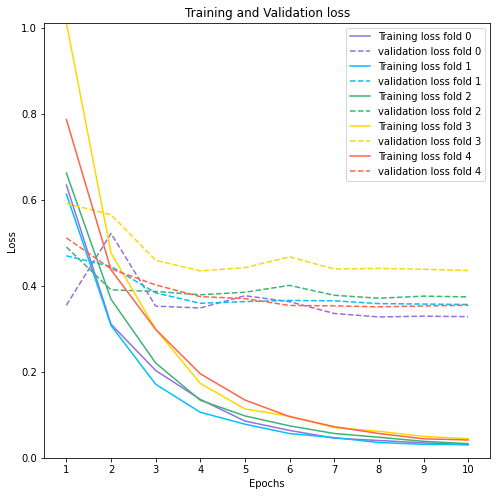

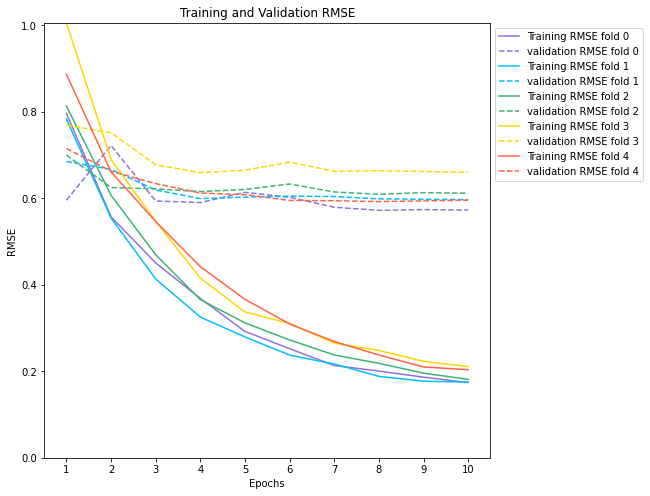

In [18]:
# print results
epochs = range(1, CFG.n_epochs + 1)
colors = ['mediumpurple', 'deepskyblue', 'mediumseagreen', 'gold', 'tomato']

# loss curve
fig = plt.figure(figsize=(8, 8))
max_y = 0
for f in range(CFG.n_folds):
    loss_train = training_evals.loc[training_evals.fold == f, 'train_loss']
    loss_val = training_evals.loc[training_evals.fold == f, 'val_loss']
    curmax = max(max(loss_train), max(loss_val))
    if curmax > max_y:
        max_y = curmax
    plt.plot(epochs, loss_train, c=colors[f], label='Training loss fold {}'.format(f))
    plt.plot(epochs, loss_val, c=colors[f], linestyle='dashed',
             label='validation loss fold {}'.format(f))

plt.title('Training and Validation loss')
plt.xticks(range(0, CFG.n_epochs + 1))
plt.xlim(0.5, CFG.n_epochs + 0.5)
plt.ylim(0, max_y)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1, 1, 0, 0))
plt.show()

# RMSE
max_y = 0
fig = plt.figure(figsize=(8, 8))
for f in range(CFG.n_folds):
    rmse_train = training_evals.loc[training_evals.fold == f, 'train_rmse']
    rmse_val = training_evals.loc[training_evals.fold == f, 'val_rmse']
    curmax = max(max(rmse_train), max(rmse_val))
    if curmax > max_y:
        max_y = curmax
    plt.plot(epochs, rmse_train, c=colors[f], label='Training RMSE fold {}'.format(f))
    plt.plot(epochs, rmse_val, c=colors[f], linestyle='dashed',
             label='validation RMSE fold {}'.format(f))
plt.title('Training and Validation RMSE')
plt.xticks(range(0, CFG.n_epochs + 1))
plt.xlim(0.5, CFG.n_epochs + 0.5)
plt.ylim(0, max_y)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(bbox_to_anchor=(1, 1, 0, 0))
plt.show()

# Inference

In [19]:
class CommonLitDataset_test(Dataset):

    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        tokenized_input = self.tokenizer(row.excerpt, return_tensors="pt",
                                         max_length=self.max_length,
                                         padding="max_length", truncation=True)

        return {
                "ids": tokenized_input["input_ids"][0],
                "masks": tokenized_input["attention_mask"][0]
        }

In [20]:
def inference(model, states, data_loader, device=device):
    """ runs inference for the test set
    takes each state (cf fold) and computes the mean of the results"""
    results = []
    n_state = 1
    with torch.no_grad():
        for state in states:
            state_results = []
            print('State {}/{}'.format(n_state, len(states)))
            model.load_state_dict(state)
            model.to(device)
            model.eval()

            for step, batch in enumerate(data_loader):
                input_ids = batch["ids"].to(device)
                attention_masks = batch["masks"].to(device)
                output = model(input_ids, attention_masks)
                predictions = flatten(output.detach().cpu().numpy())
                state_results.extend(predictions)

            results.append(state_results)
            n_state += 1

    mean_results = np.mean(results, axis=0)
    return results, mean_results

In [21]:
# get previous states from k fold
states = [torch.load(f"distilbert-base-uncased_fold_{f}_best.pth")["model"]
          for f in range(CFG.n_folds)]

# build model
model_inf = TextRegressionModel(CFG.model_name, CFG.dropout_p)

### On full dataset 
(**Warning** : this should give great RMSE as the data has been used for training)

In [22]:
# build dataset with no target
tokenizer = DistilBertTokenizer.from_pretrained(CFG.model_path)

df_train = pd.read_csv(BASE_DATA_PATH / "train.csv")
test_dataset = CommonLitDataset_test(df_train, tokenizer, CFG.max_length)

data_loader_test = DataLoader(test_dataset,
                              batch_size=CFG.batch_size, shuffle=False)

In [23]:
# predict outputs
res_states, mean_res = inference(model_inf, states, data_loader_test, device)

State 1/5
State 2/5
State 3/5
State 4/5
State 5/5


RMSE on train dataset : 0.1699


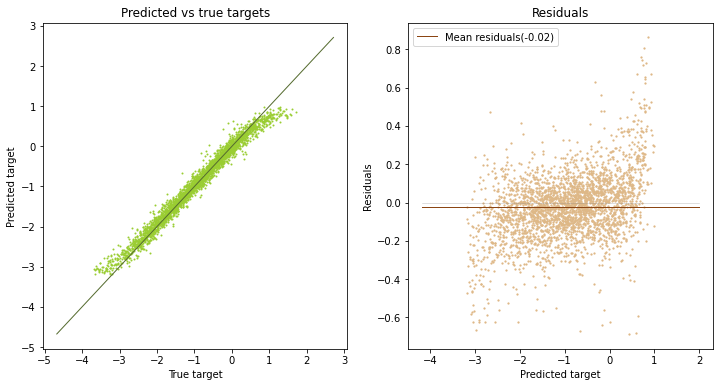

In [24]:
y_pred = mean_res
y_true = df_train.target

# compute RMSE on training set
rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
print('RMSE on train dataset :', round(rmse, 4))

# plot results
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)
xmin = np.min(y_true) - 1
xmax = np.max(y_true) + 1
axes[0].scatter(y_true, y_pred, color='yellowgreen', s=1)
axes[0].plot([xmin, xmax], [xmin, xmax],
             color='darkolivegreen', linewidth=1)
axes[0].set_xlabel('True target')
axes[0].set_ylabel('Predicted target')
axes[0].set_title('Predicted vs true targets')

residuals = y_true - y_pred
moy_residuals = np.mean(residuals)
lab = 'Mean residuals({})'.format(np.round(moy_residuals, decimals=2))

xmin = np.min(y_pred) - 1
xmax = np.max(y_pred) + 1
axes[1].scatter(y_pred, residuals, color='burlywood', s=1.5)
axes[1].plot([xmin, xmax], [0, 0], color='grey', alpha=0.5, linewidth=0.5)
axes[1].plot([xmin, xmax], [moy_residuals, moy_residuals],
             color='saddlebrown', linewidth=1, label=lab)
axes[1].set_xlabel('Predicted target')
axes[1].set_ylabel('Residuals')
axes[1].legend()
axes[1].set_title('Residuals')

plt.show()

### On test set (7 entries)

In [25]:
# build test dataset
tokenizer = DistilBertTokenizer.from_pretrained(CFG.model_path)

df_test = pd.read_csv(BASE_DATA_PATH / "test.csv")
test_dataset = CommonLitDataset_test(df_test, tokenizer, CFG.max_length)

data_loader_test = DataLoader(test_dataset,
                              batch_size=CFG.batch_size, shuffle=False)

# predict outputs
out_states, out_mean = inference(model_inf, states, data_loader_test, device)

State 1/5
State 2/5
State 3/5
State 4/5
State 5/5


In [26]:
# build submission file
df_sub = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")
df_sub["target"] = out_mean
df_sub.to_csv("submission.csv",index=False)
df_sub

,id,target
0,c0f722661,-0.726313
1,f0953f0a5,-0.549963
2,0df072751,-0.475111
3,04caf4e0c,-2.221022
4,0e63f8bea,-1.914853
5,12537fe78,-0.652984
6,965e592c0,0.221143
